In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import Preprocessing as pp

In [2]:
corr_mat = pp.data.corr()

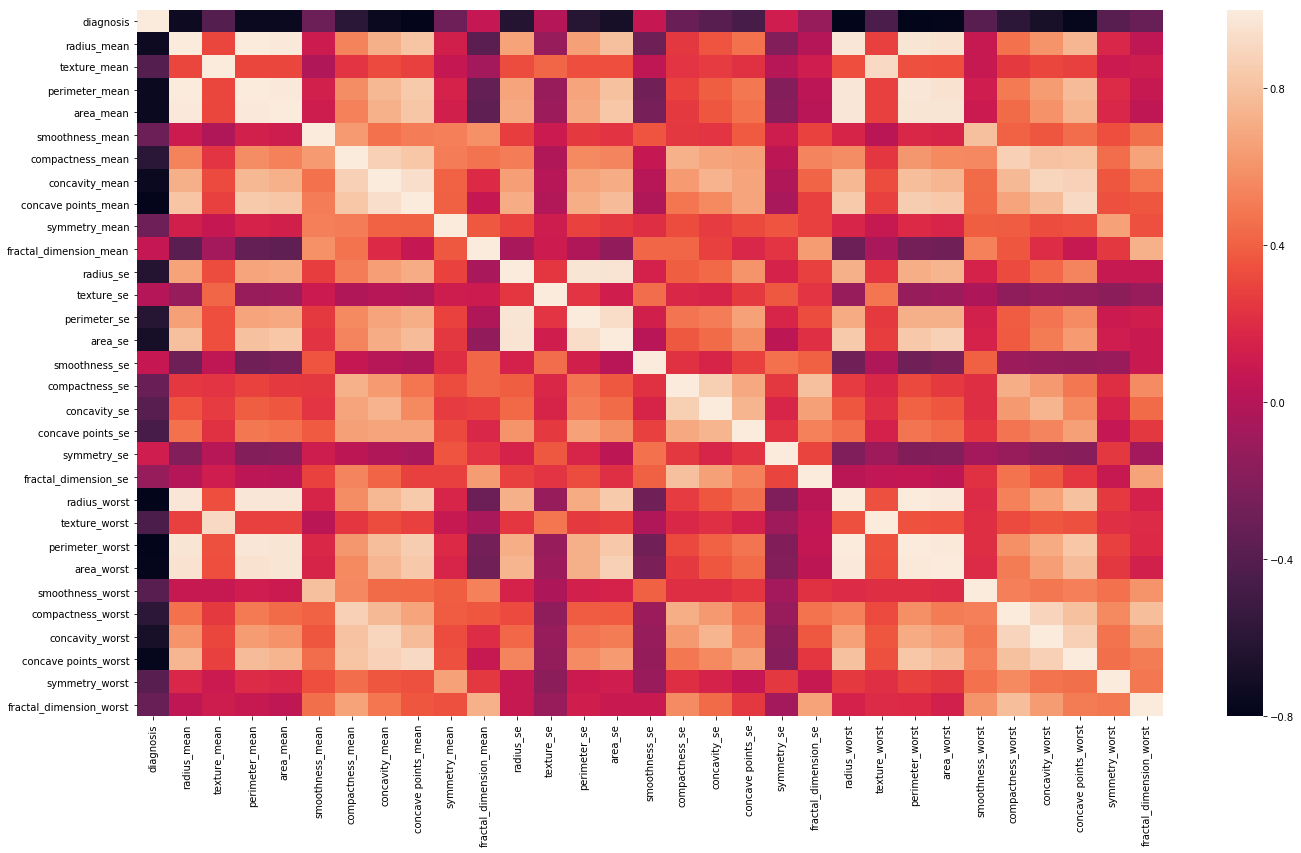

In [3]:
plt.rcParams["figure.figsize"] = (23,13)
sns.heatmap(corr_mat)
plt.show()

We're focusing on the correlation between the dependent features (diagnosis) and the independent features. So far it looks like there's little correlation between the dependent and independent features. 

In [4]:
X = pp.data_features
y = list(pp.data["diagnosis"])

In this predicitive model, "y" is our dependent variable and it labels "Malignant Cancer" as 0 and "Benign Cancer" as 1.

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
def pipe_opt(model_name,model):
    kbest = SelectKBest(f_classif)
    pipeline = Pipeline([('kbest',kbest),(model_name,model)])
    return pipeline

def get_accuracy(model):
    cv = cross_val_score(model,X_train,y_train,scoring="accuracy",cv=5)
    cv_pred = cross_val_predict(model,X_test,y_test,cv=5)
    cm = confusion_matrix(y_test,cv_pred)
    print("Cross Validated Score: \n", cv)
    print("\nConfusion Matrix: \n",cm)

In [8]:
c_param = [1,10,100,1000]

rand_grid = {'kbest__k':list(range(5,10)),
            'log__C':c_param,
            'log__random_state':[42]}

In [9]:
log_rand = RandomizedSearchCV(pipe_opt('log',LogisticRegression()),rand_grid,cv=3,
                              random_state=42,n_jobs=-1)

In [10]:
log_rand.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f13d8164950>)), ('log', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'kbest__k': [5, 6, 7, 8, 9], 'log__C': [1, 10, 100, 1000], 'log__random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [11]:
log_rand.best_params_

{'log__random_state': 42, 'log__C': 10, 'kbest__k': 9}

In [12]:
c_param = [8,10,12]

param_grid = {"kbest__k":list(range(8,12)),
             "log__C":c_param,
             "log__random_state":[42]}

In [13]:
log_grid = GridSearchCV(pipe_opt('log',LogisticRegression()),param_grid,cv=3,n_jobs=-1)

In [14]:
log_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f13d8164950>)), ('log', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [8, 9, 10, 11], 'log__C': [8, 10, 12], 'log__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [15]:
log_grid.best_params_

{'kbest__k': 9, 'log__C': 10, 'log__random_state': 42}

In [16]:
get_accuracy(log_grid)

Cross Validated Score: 
 [0.925      0.97468354 0.93670886 0.94936709 0.94936709]

Confusion Matrix: 
 [[37  1]
 [ 1 60]]


The model appears to be performing well and it doesn't appear that the model is overfitting.

## Getting top features for predicting type of breast cancer

In [17]:
selector = SelectKBest(f_classif,k=9)
selector.fit(X_train,y_train)

SelectKBest(k=9, score_func=<function f_classif at 0x7f13d8164950>)

In [18]:
idxs_selected = selector.get_support()

In [19]:
breast_cancer_features = X_train.columns[idxs_selected]

In [20]:
breast_cancer_features

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')

The following traits indicate the type of cancer the patient will be diagnosed with:

1) Radius_mean: mean of distances from center of cancer cell to points on the perimeter

2) Perimeter_mean: mean size of the core tumor

3) Area_mean: mean area of cancer cell

4) Concavity_mean: mean of severity of concave portions of the contour shape of cell

5) Concave_points_mean: mean for the number of concave portions of the contour shape of cell

6) Radius_worst: "worst" or largest mean value for mean of distances from center to points on the perimeter

7) Perimeter_worst: largest mean value for size of the core tumor

8) Area_worst: largest mean value for area of cancer cell

9) Concave_points_worst: largest mean value for number of concave portions

It looks like there's a lot of multicollinearity present in the model. Going back to the correlation matrix, a lot of the independent features were correlated with each other. In other words, we are not getting a whole lot of new information from each of the independent features.

We could apply PCA to the independent features to reduce multicollinearity, but we would lose the interpretability of the features.